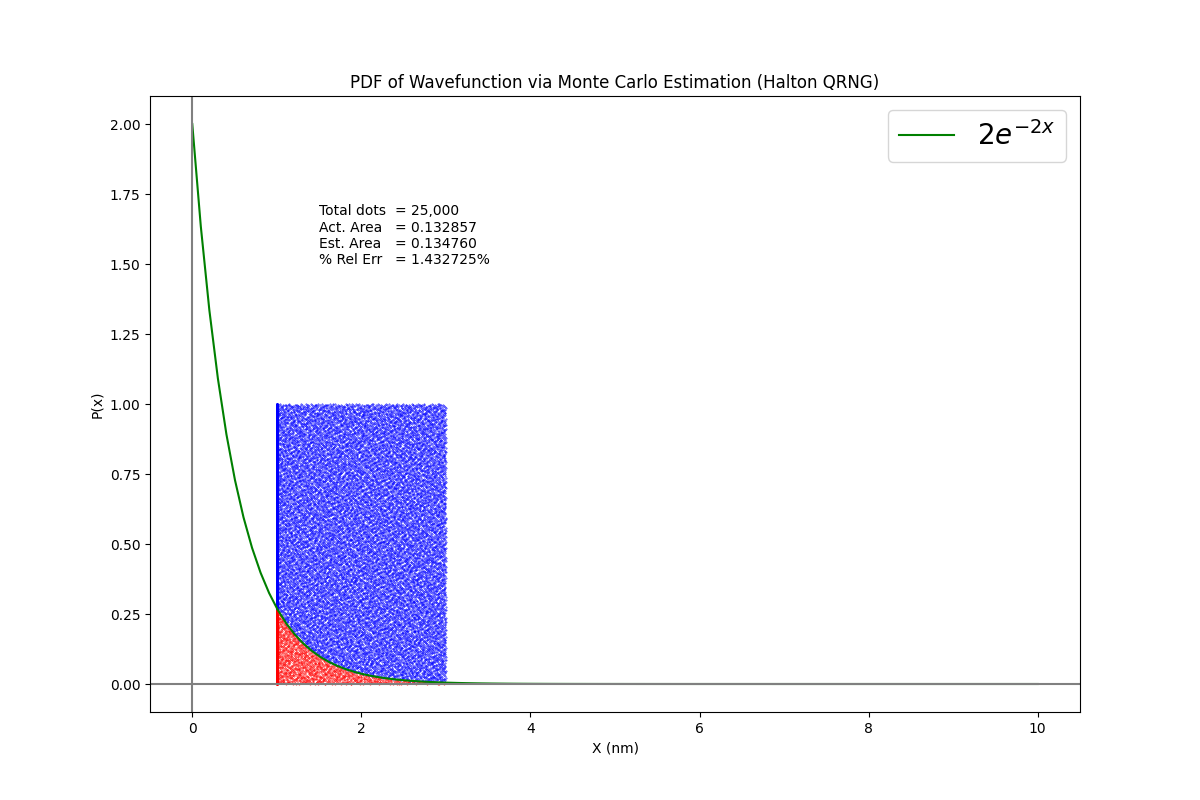

In [3]:
"""particle_location.ipynb"""


# Cell 1 -> Uses matplotlib and Monte Carlo estimation to draw the PDF and to estimate the probability a particle will be found in the region 𝑥≥1𝑛𝑚. 
# Displays the % relative error in the estimate compared to the analytic solution. 

# Analytic answers found and checked with https://www.wolframalpha.com/input?i=integral+from+1+to+infinity+for+2*e%5E%28-2x%29+dx.
# Code is also aided by: https://numpy.org/doc/stable/reference/generated/numpy.clip.html 

# Used for type hinting
from __future__ import annotations
# Used for type hinting
import typing
# Used for plotting 
import matplotlib.pyplot as plt
# Used for calculations
import numpy as np
# Used for graphing style
from matplotlib.markers import MarkerStyle
# Allows us to use large numbers to increase algorithm efficiency 
from numba import float64, vectorize  # type: ignore


if typing.TYPE_CHECKING:
    # Type checking for axes and arrays 
    from matplotlib.axes import Axes
    from numpy.typing import NDArray


# Allows the menu bar on the side of the plot to appear 
%matplotlib widget


def f(x: NDArray[np.float_]) -> NDArray[np.float_]:
    """Actual implementation of the wavefunction pdf"""
    # Helps us determine if we are above or below the curve 
    # c= +/- sqrt(2)
    # PDF= |𝜓(𝑥)|^2= < 𝜓(𝑥)| 𝜓(𝑥)> (conjugate transpose of a real function is just itself), so =(c^2(e^-x/1))^2= 2e^-2x
    # f(x)= 2e^(-2*x)
    return 2 *(np.e**(-2*x))

def cdf (x:float)-> float: 
    """Define the cdf"""
    return 1-np.exp(-2*x)

# vectorize-> numba package to make it run fast 
@vectorize([float64(float64, float64)], nopython=True)  # type: ignore
def halton(n: float, p: int) -> float:
    """Generate random points"""
    # Takes an index (n) and a base (p) as its inputs 
    # Initialize h and f 
    h = 0
    f = 1
    # loop runs until index becomes 0 
    while n > 0:
        # Scale down the factor to create digits in Halton sequence 
        f: float = f / p
        # Calculate the remainder of n/p and multiply it by f 
            # Update h in the overall halton sequence 
        h += (n % p) * f
        # Update n by performing integer division 
        n = int(n / p)
    return h



def plot_exponential_distribution(ax: Axes) -> None:
    # 25,000 dots 
    iterations: int = 25_000

    # 2 dimensions, give halton 1st 2 primes 
    primes: list[int] = [2, 3]

    # Constrain x to be within our sample space-> the graph only appears to have an area up until x=3
    scale_factor_x: float = 3.0
    
    # Use np.clip to plot monte carlo for x>=1nm
    x: NDArray[np.float_] = np.clip(halton(np.arange(iterations), primes[0])*scale_factor_x, 1, scale_factor_x) # type: ignore
    y: NDArray[np.float_] = halton(np.arange(iterations), primes[1])# type: ignore
    # distance -> difference between actual height - y value we picked 
        # tells us are we above or below 
    d: NDArray[np.float_] = f(x) - y
    
    # filters to make 2 different lists 
        # inner points have a distance greater than/equal to 0 
    x_in: NDArray[np.float_] = x[d >=0.0]
    y_in: NDArray[np.float_] = y[d >=0.0]
        # outer points have a distance less than 0 
    x_out: NDArray[np.float_] = x[d <0.0 ]
    y_out: NDArray[np.float_] = y[d <0.0 ]
    # Count the number of points within the area
    count_points:int = np.count_nonzero(d >=0.0)
    # Plot a scatter plot of the Monte Carlo simulation using pixel sized points 
    pixel_size: float = (72 / ax.figure.dpi) ** 2  # type: ignore
    ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
    ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)
  
        
    # plot actual 
        # define arrays of the actual x and y values based on the actual PDF 
    act_x: NDArray[np.float_] = np.linspace(0, 10, 100)
    act_y: NDArray[np.float_] = f(act_x)
    ax.plot(
        act_x, act_y, color="green", label=r"$2e^{-2x}$" 
    )
    # Monte carlo formula 
        # calculate the estimated area based on the inner points and the iterations
    est_area: float = count_points / (iterations)

    # Actual area found on WolframAlpha
    act_area: float= cdf(3)-cdf(1)
    # Calculate the error 
    err: float = (est_area - act_area) / act_area
    
    ax.set_title("PDF of Wavefunction via Monte Carlo Estimation (Halton QRNG)")
    
    ax.set_xlabel ("X (nm)")
    ax.set_ylabel("P(x)")
    ax.axhline(0, color="gray")
    ax.axvline(0, color="gray")
    ax.legend(loc="upper right", fontsize="20")

    ax.text(1.5, 1.5, "Total dots\nAct. Area\nEst. Area\n% Rel Err", ha="left")

    # fmt: off
    ax.text(2.4, 1.5,
        f"= {iterations:,}\n= {act_area:.6f}\n= {est_area:.6f}\n= {err:.6%}", ha="left")
    # fmt: on


def main() -> None:
    """Define an entry point for the code"""
    # Open a new plot window and show the plot 
    plt.close("all")
    plt.figure(" ", figsize=(12, 8))
    plot_exponential_distribution(plt.axes())
    plt.show()

# Call the main function 
main()

In [2]:
# Cell 2-> Uses SciPy Integrate to numerically estimate the same probability as Cell 1

# Integration for the area under the curve
from scipy.integrate import quad  # type:ignore

# Calculate the actual area using scipy integrate function
act_area: float = quad(f, 1, np.inf)[0]
print(f"Actual area using scipy integration methods: {act_area:.6f}")
print(f"Probability of {act_area*100:.4f}%")

Actual area using scipy integration methods: 0.135335
Probability of 13.5335%
